Importing require modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from keras.utils import get_custom_objects
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
seed = 1234
np.random.seed(seed)
plt.style.use('ggplot')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Loading Data (BTC, ETH, XAU, SOL - USD - 5 minute interval data)

In [3]:
btc = pd.read_csv('./Data/btcusd_5-min_data.csv')
btc['Datetime'] = pd.to_datetime(btc['Timestamp'], unit='s')
btc.set_index('Datetime', inplace=True)
eth = pd.read_csv('./Data/ethusd_5-min_data.csv')
eth['Datetime'] = pd.to_datetime(eth['timestamp'], unit='s')
eth.set_index('Datetime', inplace=True)
xau = pd.read_csv('./Data/xauusd_5-min_data.csv')
xau['Datetime'] = pd.to_datetime(xau['Date'])
xau.set_index('Datetime', inplace=True)
sol = pd.read_csv('./Data/solusd_5-min_data.csv')
sol['Datetime'] = pd.to_datetime(sol['Timestamp'], unit='s')
sol.set_index('Datetime', inplace=True)

Draw BTC-USD, ETH-USD, XAU-USD, SOL-USD data

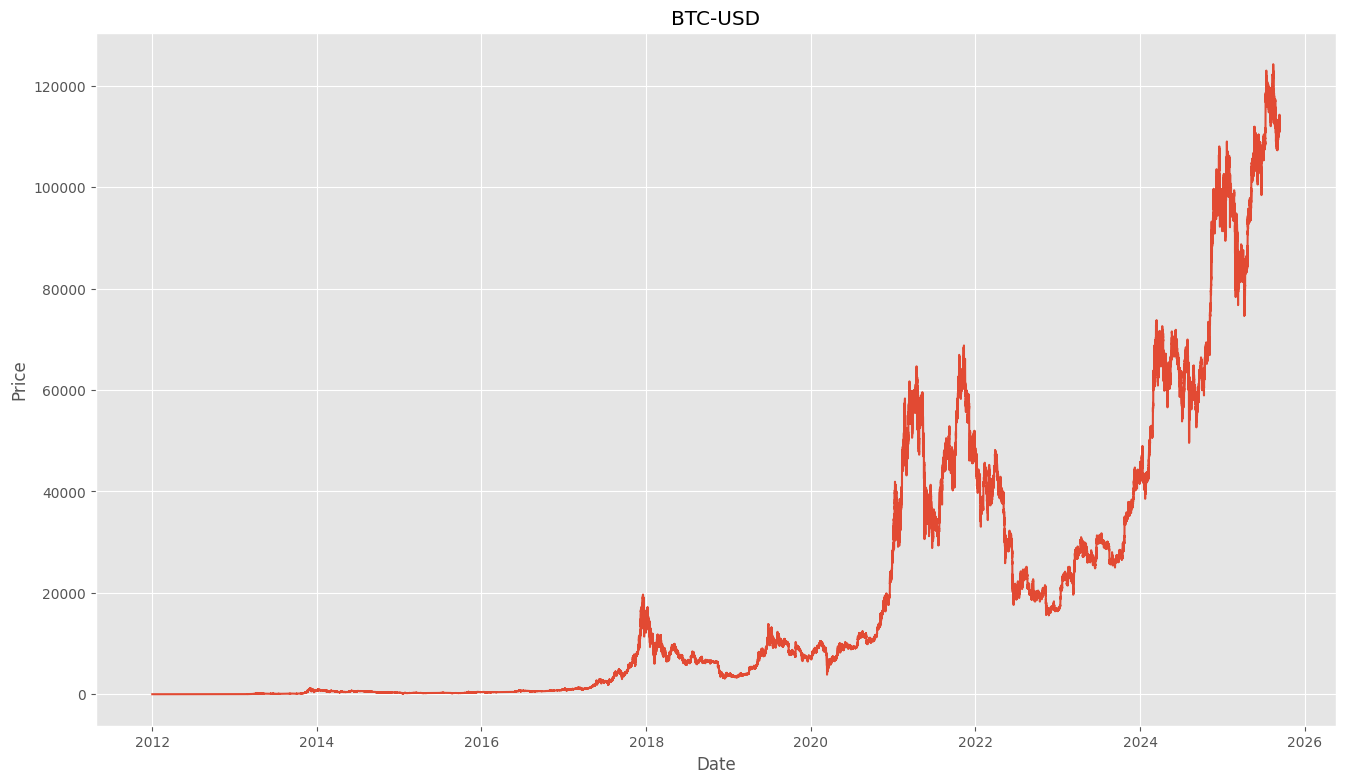

In [4]:
fig = plt.figure(figsize=(16, 9))
plt.plot(btc.Close)
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.title('BTC-USD')
plt.show()

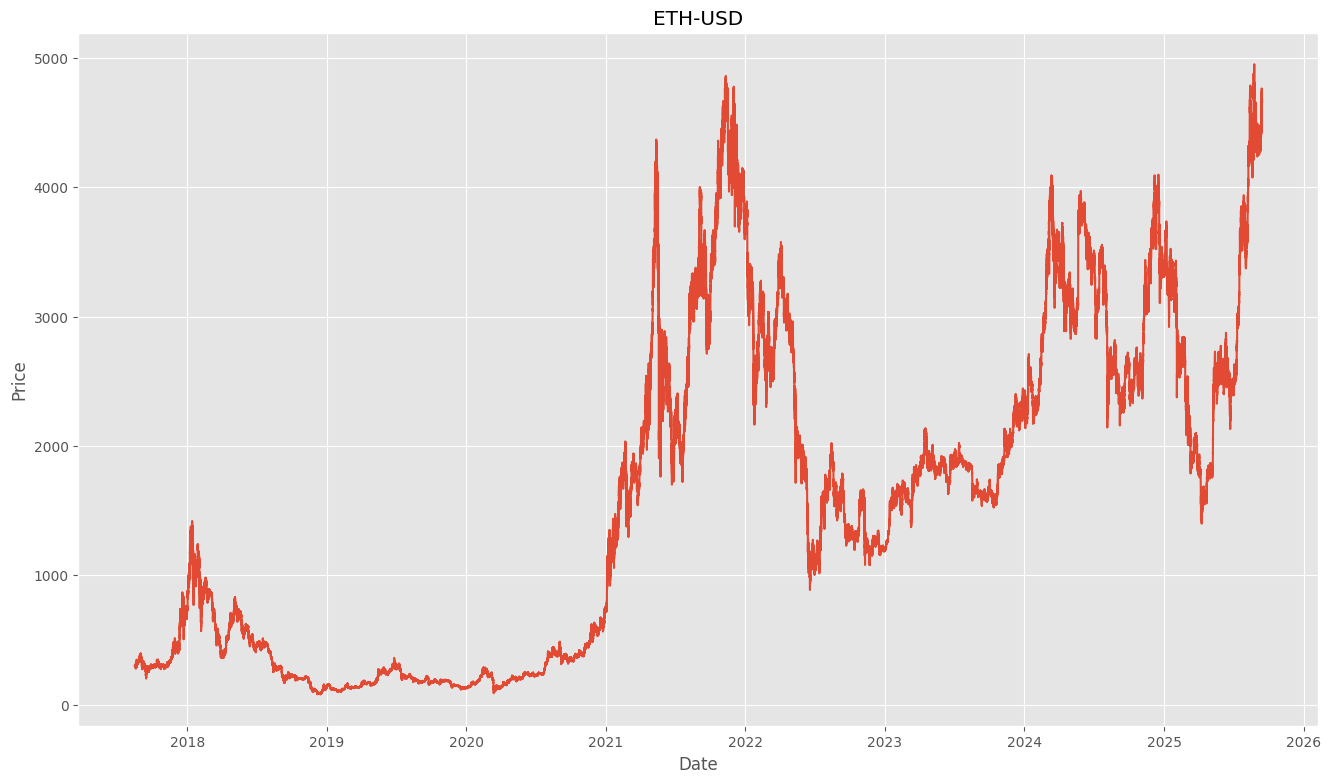

In [5]:
fig = plt.figure(figsize=(16, 9))
plt.plot(eth.close)
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.title('ETH-USD')
plt.show()

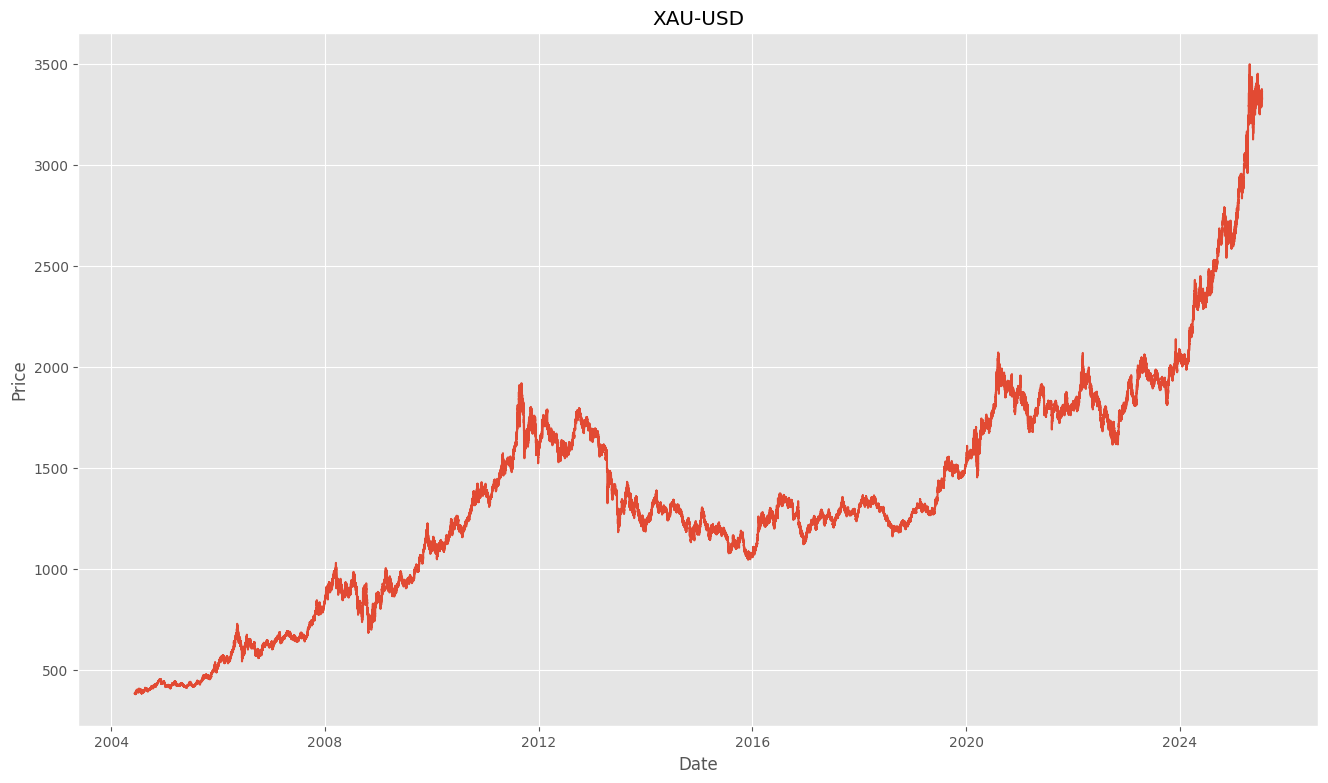

In [6]:
fig = plt.figure(figsize=(16, 9))
plt.plot(xau.Close)
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.title('XAU-USD')
plt.show()

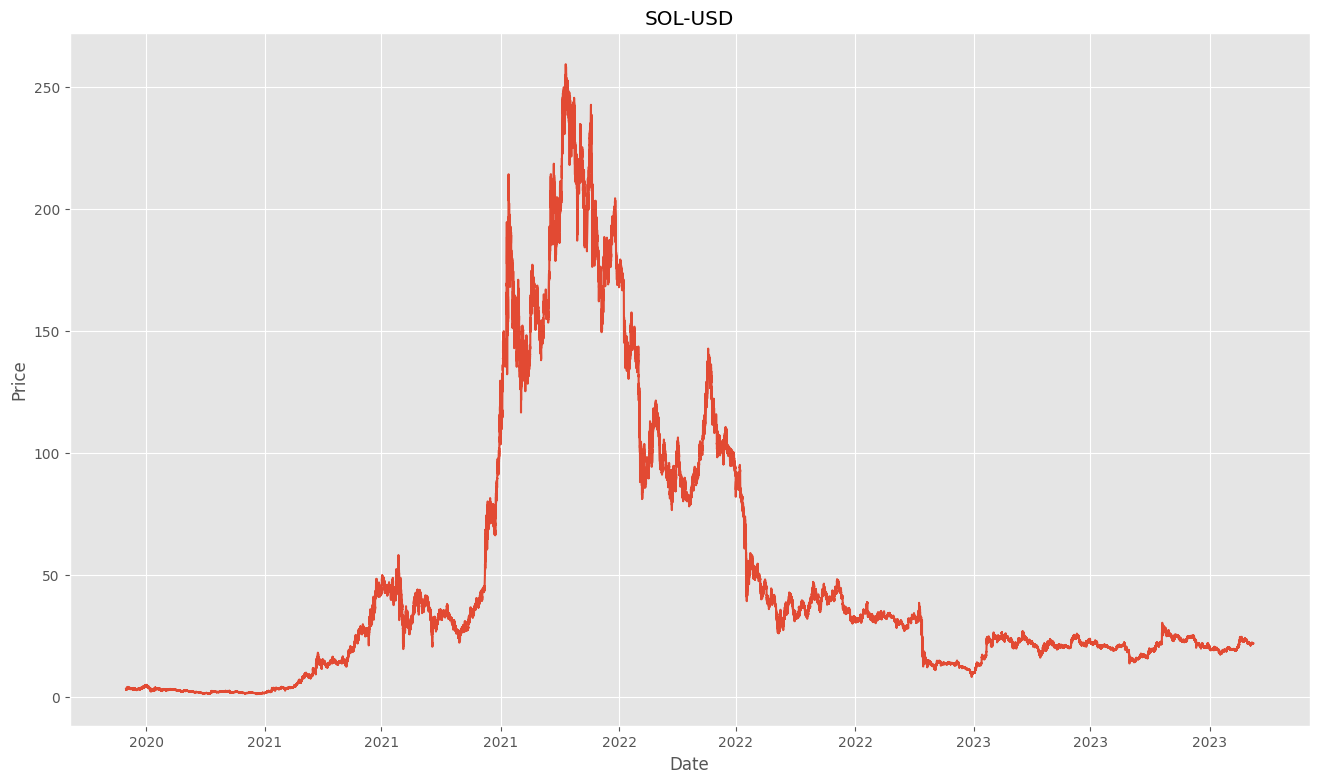

In [7]:
fig = plt.figure(figsize=(16, 9))
plt.plot(sol.Close)
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.title('SOL-USD')
plt.show()

Data Spliting & Scaling

In [8]:
btc_scaler = MinMaxScaler()
btc = btc_scaler.fit_transform(btc[['Close']])
btc_len = len(btc)
btc_train = btc[:int(btc_len * 0.8)]
btc_val = btc[int(btc_len * 0.8):int(btc_len * 0.9)]
btc_test = btc[int(btc_len * 0.9):]

eth_scaler = MinMaxScaler()
eth = eth_scaler.fit_transform(pd.DataFrame(eth[['close']]))
eth_len = len(eth)
eth_train = eth[:int(eth_len * 0.8)]
eth_val = eth[int(eth_len * 0.8):int(eth_len * 0.9)]
eth_test = eth[int(eth_len * 0.9):]

xau_scaler = MinMaxScaler()
xau = xau_scaler.fit_transform(pd.DataFrame(xau[['Close']]))
xau_len = len(xau)
xau_train = xau[:int(xau_len * 0.8)]
xau_val = xau[int(xau_len * 0.8):int(xau_len * 0.9)]
xau_test = xau[int(xau_len * 0.9):]

sol_scaler = MinMaxScaler()
sol = sol_scaler.fit_transform(pd.DataFrame(sol[['Close']]))
sol_len = len(sol)
sol_train = sol[:int(sol_len * 0.8)]
sol_val = sol[int(sol_len * 0.8):int(sol_len * 0.9)]
sol_test = sol[int(sol_len * 0.9):]

Create sliding windows into data

In [30]:
def create_sliding_windows(data, lag, step = 1):
    len_data = len(data)
    x = []
    y = []
    for i in range(lag, len_data - lag, step):
        x.append(data[i - lag:i, 0])
        y.append(data[i:i + lag, 0])
    return np.array(x), np.array(y)

BTC-USD

In [10]:
train_x, train_y = create_sliding_windows(btc_train, 289)
val_x, val_y = create_sliding_windows(btc_val, 289)
test_x, test_y = create_sliding_windows(btc_test, 289, 289)

ETH-USD

In [11]:
train_x, train_y = create_sliding_windows(eth_train, 289)
val_x, val_y = create_sliding_windows(eth_val, 289)
test_x, test_y = create_sliding_windows(eth_test, 289, 289)

XAU-USD

In [25]:
train_x, train_y = create_sliding_windows(xau_train, 289)
val_x, val_y = create_sliding_windows(xau_val, 289)
test_x, test_y = create_sliding_windows(xau_test, 289, 289)

SOL-USD

In [31]:
train_x, train_y = create_sliding_windows(sol_train, 289)
val_x, val_y = create_sliding_windows(sol_val, 289)
test_x, test_y = create_sliding_windows(sol_test, 289, 289)
test_x, test_y

(array([[0.06216069, 0.06185102, 0.06181231, ..., 0.06103813, 0.06099943,
         0.06092201],
        [0.0608833 , 0.0608833 , 0.0608833 , ..., 0.06173489, 0.0617736 ,
         0.06173489],
        [0.06161877, 0.06165748, 0.06165748, ..., 0.06072846, 0.06065105,
         0.06057363],
        ...,
        [0.0817474 , 0.08163127, 0.08178611, ..., 0.07977324, 0.0800055 ,
         0.07996679],
        [0.07985066, 0.07988937, 0.07981195, ..., 0.07776038, 0.07768296,
         0.07779909],
        [0.07772167, 0.07779909, 0.07776038, ..., 0.08139902, 0.0813216 ,
         0.08116676]], shape=(114, 289)),
 array([[0.0608833 , 0.0608833 , 0.0608833 , ..., 0.06173489, 0.0617736 ,
         0.06173489],
        [0.06161877, 0.06165748, 0.06165748, ..., 0.06072846, 0.06065105,
         0.06057363],
        [0.06049621, 0.06049621, 0.06041879, ..., 0.06165748, 0.06146393,
         0.06146393],
        ...,
        [0.07985066, 0.07988937, 0.07981195, ..., 0.07776038, 0.07768296,
         0.07779

In [16]:
def get_model() -> Sequential:
    model = Sequential()
    model.add(GRU(units=145, return_sequences=True, input_shape=(289,1)))
    model.add(Dropout(0.2))
    model.add(GRU(units=73, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(units=73, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=289))
    model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error')
    return model

def save_model(model: Sequential, filename: str):
    model.save(f"./model/{filename}.model")

def load_model(filename) -> Sequential:
    model = get_model()
    model.load_weights(f"./model/{filename}.model")
    return model

Training

In [17]:
model = get_model()
callbacks = [EarlyStopping(patience=10, restore_best_weights=True), ReduceLROnPlateau(factor=0.1, patience=10)]
model.fit(train_x, train_y, validation_data=(val_x,val_y), batch_size=128, epochs=180, callbacks=callbacks)

Epoch 1/180


KeyboardInterrupt: 

Test model

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
Result Root Mean Square Error Prediction Model : 319.4569
Result Mean Absolute Percentage Error Prediction Model :  318741.5653 %


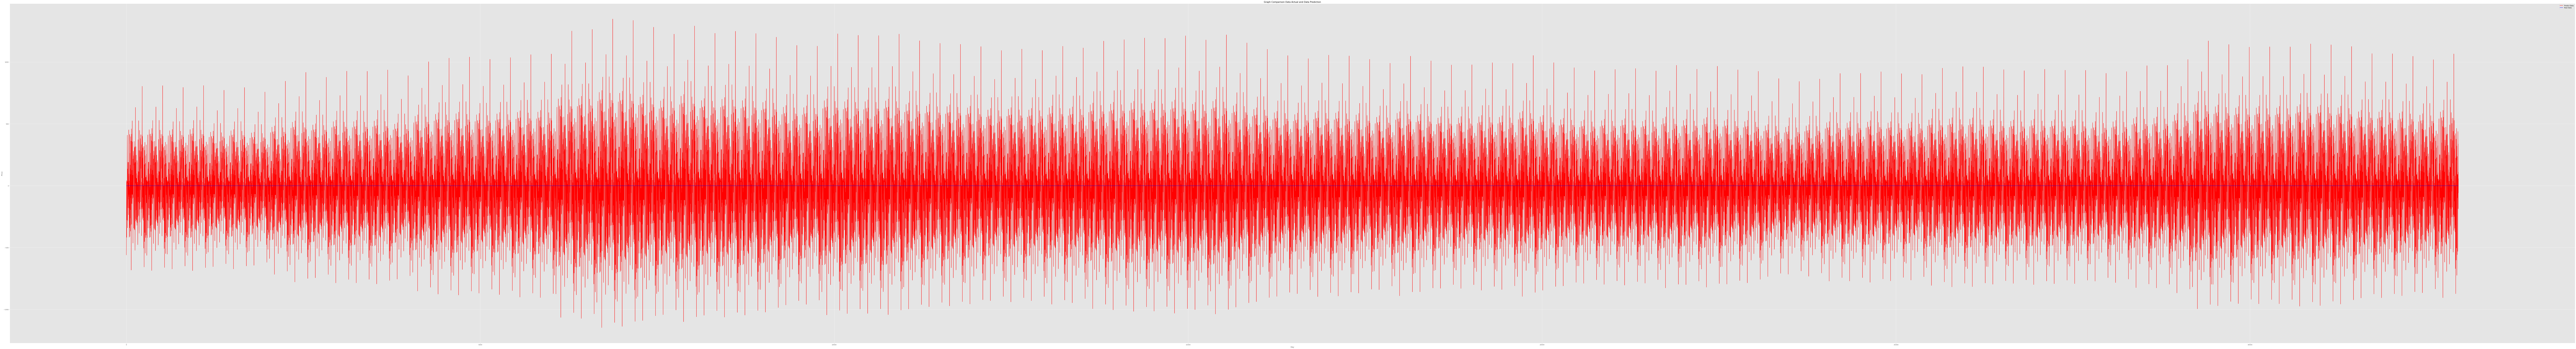

In [33]:
predict = model.predict(test_x)
predict_vec = btc_scaler.inverse_transform(predict)
pre_result = np.reshape(predict_vec, [predict_vec.shape[0] * predict_vec.shape[1]])
test_y = np.reshape(test_y, [test_y.shape[0] * test_y.shape[1]])
datacompare = pd.DataFrame()
datacompare['Predict Data'] = pre_result
datacompare['Real Data'] = test_y

# Calculatre value of Root Mean Square Error 
def rmse(datatest, datapred):
    return np.round(np.sqrt(np.mean((datapred - datatest) ** 2)), 4)
print('Result Root Mean Square Error Prediction Model :',rmse(test_y, pre_result))

def mape(datatest, datapred): 
    return np.round(np.mean(np.abs((datatest - datapred) / datatest) * 100), 4)
    
print('Result Mean Absolute Percentage Error Prediction Model : ', mape(test_y, pre_result), '%')
# Create graph data test and prediction result
plt.figure(num=None, figsize=(300, 40), dpi=80,facecolor='w', edgecolor='k')
plt.title('Graph Comparison Data Actual and Data Prediction')
plt.plot(datacompare['Predict Data'], color='red',label='Predict Data')
plt.plot(datacompare['Real Data'], color='blue',label='Real Data')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()